In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label

In [84]:
# Working through the hooks puzzles.
# starting from hooks #3
# determine the hook and then solve row by row,
# very slow. Need to alternate row and column I think

url='https://www.janestreet.com/puzzles/hooks-4/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:]))

The grid presented here can be partitioned into 9 L-shaped “hooks”. The largest is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains 15 squares), and so on. The smallest hook is just a single square. Find where the hooks are located, and place nine 9’s in the largest hook, eight 8’s in the next-largest, etc., down to one 1 in the smallest hook. The filled squares must form a connected region. (Squares are “connected” if they are orthogonally adjacent.) A number outside the grid indicates the sum of the products of consecutive groups of squares in that row or column. (As shown in the example.) The answer to this puzzle is the product of the areas of the connected groups of empty squares in the completed grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/aug18_puzzle_bold.png" width="300" height="300">

In [2]:
#Setup the constraints
top_labels = [28,552,64,15,86,1304,170,81,810]
right_labels =[810,585,415,92,67,136,8,225,567]

In [3]:
class Matrix():
    def __init__(self,top_labels,right_labels):
        self.top_labels = top_labels
        self.right_labels = right_labels
        self.potential_grids = [[-9,np.ones((9,9),dtype=int)*-1,[0,0,9,9]]] # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled]
        self.solution = []
        self.splits =  [list(i) for i in itertools.product([0, 1], repeat=9)]
     
    ########################################################################################
    # Code to get the initial valid grids

    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
    
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_start +=1
    
        elif alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_start +=1 

        elif alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_end -=1
        
        else: # alignment == 3:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_end -=1 
    
        coords = [row_start,col_start,row_end, col_end]
        
        return grid,coords    
   
    def check_grid(self,grid):
        isValid = 1
        for i in range(9):
            row = grid[i,:]
            col = grid[:,i]
            if -1 not in row:
                    isValid *= self.check_line(row,self.right_labels[i])
            if -1 not in col:
                    isValid *= self.check_line(col,self.top_labels[i])  
        return isValid
                    
    def check_line(self,line,param):
        for split in self.splits:
            test = line * split
            if self.valid_line(test,param):
                return 1
        return 0
    

    def valid_line(self,pos,param):
        total =0
        block = 1
        inblock =0
        for p in pos:
            if p !=0:
                block *= p
                inblock = 1
            else:
                if inblock == 1:
                    total += block
                    block = 1
                    inblock = 0
        if block > 1:
            total +=block
        if total == param:
            return True
        else:
            return False
        
    def fill_rest(self,grid,hooks):
        for row in range(9):
            if -1 in grid[row,:]:
                for split in self.splits : 
                    if self.possible(split,row,grid,hooks):
                        grid[row,:] = split
                        self.fill_rest(grid,hooks)
                        grid[row,:] =np.ones(9)*-1
                return
        sol_print(grid,hooks)              
                           
           
            
    def possible(self,split,row,grid,hooks):
        test = dcopy(grid)
        test[row,:] = split
        test = test*hooks
    
    #check the placement doesn't break connectivity
        if np.max(label(test!=0,connectivity=1)) > 1:
            return False
    
                
        #check rows and columns   
        check_row = test[row,:]
        if not self.valid_line(check_row,self.right_labels[row]):
            return False
        
    # final checks if the placement completes the grid    
        if np.sum(test < 0) ==0:
            
    
        #check rows and columns again
            for i in range(9):
                row = test[i,:]
                if not self.valid_line(row,self.right_labels[i]):
                    return False
                col = test[:,i]
                if not self.valid_line(col,self.top_labels[i]):
                    return False                
        return True      

       
    def solve(self):
           
        while len(self.potential_grids) > 0:
            
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
        
            for alignment in range(4):
                lvl,grid,coords = dcopy(temp_grid)
                grid,coords = self.add_layer(grid,coords,-lvl,alignment)
                if lvl != -1 :
                    rotations.append([lvl+1,grid,coords])
                else:
                     rotations = [[lvl+1,grid,coords]]
    
            #check valid grids (where the sum can be made from available digits) and save the ones that work
            for i in range(len(rotations)):
                lvl,g,coords = rotations[i]
                if self.check_grid(g):
                    if lvl !=0:    
                        self.potential_grids.append([lvl,g,coords])
                    else:
                        self.solution.append(g)
                        

        print("There are {} valid hook placements".format(len(self.solution)))
            

        #solve each grid in the cut down list
        forced_grids = []
        for i in range(len(self.solution)):
            print("Checking: ",i)
            hooks = self.solution[i]
            #print(hooks)
            forced_grid =np.ones((9,9),dtype= int)*-1
            self.fill_rest(forced_grid,hooks)
            
        
#########################
# Code to print in a "nice" format
                            
def sol_print(solved,matrix):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(matrix,annot=x,cbar=False,cmap="Set3_r",fmt="",linewidths=0.25)
    ax.axis("off")

There are 4 valid hook placements
Checking:  0
Checking:  1
Checking:  2
Checking:  3

 Solution took 445.2529 seconds



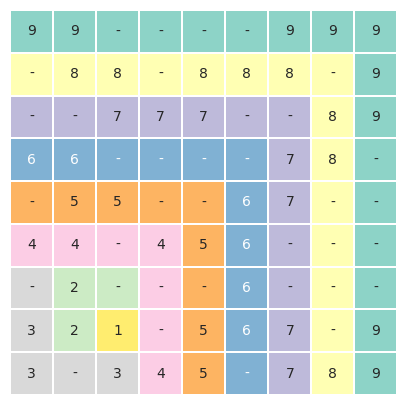

In [4]:
start = time.perf_counter()
test = Matrix(top_labels,right_labels)
test.solve()
stop =  time.perf_counter()
print('\n Solution took {:0.4f} seconds\n'.format((stop-start)))

### Puzzle solution
<img src="https://www.janestreet.com/puzzles/20180801_hooks_4_ans.png" width="300" height="400">

In [37]:
test_grid =np.array([[1,1,0,0,0,0,1,1,1],
             [0,1,1,0,1,1,1,0,1],
             [0,0,1,1,1,0,0,1,1],
             [1,1,0,0,0,0,1,1,0],
             [0,1,1,0,0,1,1,0,0],
             [1,1,0,1,1,1,0,0,0],
             [0,1,0,0,0,1,0,0,0],
             [1,1,1,0,1,1,1,0,1],
             [1,0,1,1,1,0,1,1,1]
             ])

test_hook =np.array([[9,9,9,9,9,9,9,9,9],
             [8,8,8,8,8,8,8,8,9],
             [7,7,7,7,7,7,7,8,9],
             [6,6,6,6,6,6,7,8,9],
             [5,5,5,5,5,6,7,8,9],
             [4,4,4,4,5,6,7,8,9],
             [3,2,2,4,5,6,7,8,9],
             [3,2,1,4,5,6,7,8,9],
             [3,3,3,4,5,6,7,8,9]
             ])

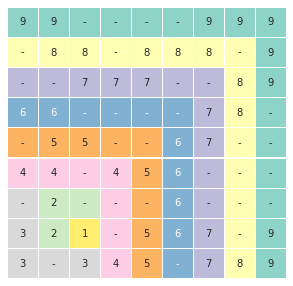

In [26]:
sol_print(test_grid,test_hook)